In [118]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.naive_bayes import GaussianNB, CategoricalNB, BernoulliNB
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from scipy.signal import savgol_filter
import matplotlib.ticker as plticker


In [119]:
# writer = pd.ExcelWriter("Ket qua phan loai khong dao ham.xlsx", engine='xlsxwriter')

In [120]:
data = pd.read_excel("../../data/Dataset_HPLC.xlsx", sheet_name="Vungtrong (140)")
data.head(5)

,No.,Name,Group,%CM,%CA,%CAL,600,602,604,606,...,3982,3984,3986,3988,3990,3992,3994,3996,3998,4000
0,1,21.1.8.YB-13,1,2.57,0.09,9.83,0.222,0.223,0.221,0.217,...,-0.006,-0.006,-0.006,-0.006,-0.006,-0.006,-0.006,-0.006,-0.006,-0.006
1,2,21.1.8.YB-24,1,0.69,0.04,3.75,0.263,0.261,0.257,0.257,...,-0.007,-0.007,-0.007,-0.007,-0.006,-0.007,-0.007,-0.007,-0.007,-0.007
2,3,21.1.8.YB-38,1,0.43,0.05,5.53,0.252,0.253,0.253,0.252,...,-0.006,-0.007,-0.007,-0.007,-0.006,-0.007,-0.007,-0.007,-0.007,-0.007
3,4,21.1.8.YB-40,1,2.04,0.06,5.21,0.259,0.258,0.259,0.259,...,-0.008,-0.009,-0.009,-0.009,-0.008,-0.008,-0.008,-0.009,-0.009,-0.009
4,5,21.1.8.YB-41,1,0.13,0.09,4.60,0.206,0.203,0.200,0.198,...,0.000,-0.001,0.000,0.001,0.001,0.000,0.000,-0.001,-0.001,-0.001


In [121]:
y = data["Group"]
# le = LabelEncoder()
# y = le.fit_transform(y)
X = data.iloc[:, 6:]
X.columns = X.columns.astype(str)
wl = X.columns.astype(float)
# print(np.unique(y))
# print(le.inverse_transform(np.unique(y)))

In [122]:
X = savgol_filter(X, window_length=25, polyorder=5, deriv=1)

In [123]:
X = pd.DataFrame(X, columns=wl)
X_origin = X.copy(deep=True)


C:\Users\84866\AppData\Local\Temp\ipykernel_11204\495723894.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),rotation=45, ha='right')


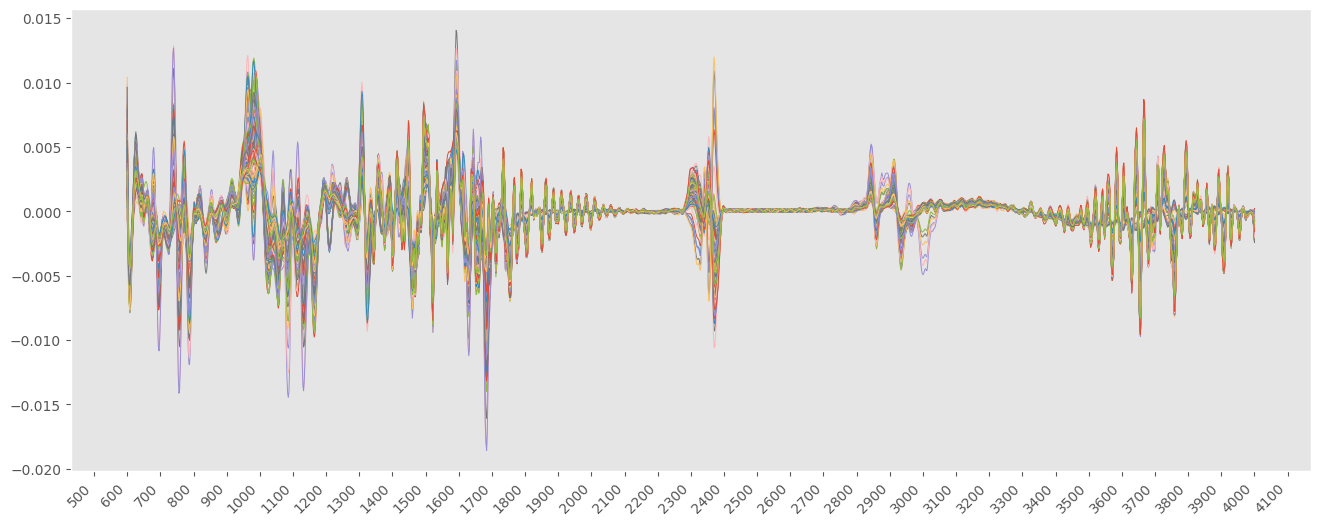

In [124]:
fig, ax = plt.subplots(figsize = (16, 6))
ax.plot(X.T, linewidth = 0.7)
loc = plticker.MultipleLocator(base=100.0) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
# ax.set_xticks(rotation = 90)
plt.grid()
ax.set_xticklabels(ax.get_xticklabels(),rotation=45, ha='right')
plt.show()

In [125]:
X = np.array(X)  # In case it's not already a NumPy array
y = np.array(y)

n_classes = len(np.unique(y))
# Define how many samples per class you want in the validation set
n_test_samples_per_class = int(len(X) * 0.25 / n_classes)  # Modify this based on your need

# Get unique class labels
classes = np.unique(y)
# Lists to hold train and test data
X_train_list, X_test_list = [], []
y_train_list, y_test_list = [], []

# For each class, split data to have equal test size
for cls in classes:
    # Get indices for this class
    class_indices = np.where(y == cls)[0]
    
    # Split the data for this class
    X_class, X_class_test, y_class, y_class_test = train_test_split(
        X[class_indices], y[class_indices], test_size=n_test_samples_per_class, random_state=42
    )
    
    # Append the splits to the train/test lists
    X_train_list.append(X_class)
    X_test_list.append(X_class_test)
    y_train_list.append(y_class)
    y_test_list.append(y_class_test)

# Combine back into arrays
X_train = np.vstack(X_train_list)  # Combine all classes' training data
X_test = np.vstack(X_test_list)      # Combine all classes' test data
y_train = np.hstack(y_train_list)  # Combine all classes' training labels
y_test = np.hstack(y_test_list)      # Combine all classes' test labels

print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_test.shape, y_test.shape)

Training set shape: (107, 1701) (107,)
Validation set shape: (32, 1701) (32,)


In [126]:

# scaler = MinMaxScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.fit_transform(X_test)

In [127]:
wl = wl.astype(float)

In [128]:
import numpy as np
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_score
from joblib import Parallel, delayed
from sys import stdout

def pls_variable_selection(X, y, max_comp, cv=5, n_jobs=-1):
    """
    Optimized PLS variable selection with cross-validation and parallelization.

    Parameters:
    - X: Input feature matrix (n_samples, n_features)
    - y: Target variable
    - max_comp: Maximum number of components for PLS
    - cv: Number of cross-validation folds
    - n_jobs: Number of jobs for parallelization (default is -1, which uses all cores)

    Returns:
    - Xc: Optimized feature matrix after wavelength selection
    - optimal_components: The optimal number of PLS components
    - optimal_wavelengths: Wavelengths (features) to be discarded
    - sorted_indices: Indices of sorted features based on PLS coefficients
    """
    
    # Define MSE array to be populated
    mse = np.zeros((max_comp, X.shape[1]))

    # Loop over the number of PLS components
    for i in range(max_comp):
        # Regression with specified number of components, using full spectrum
        pls1 = PLSRegression(n_components=i + 1)
        pls1.fit(X, y)
        
        # Indices of sorted spectra according to ascending absolute value of PLS coefficients
        sorted_ind = np.argsort(np.abs(pls1.coef_).flatten())
        
        # Sort spectra accordingly
        Xc = X[:, sorted_ind]

        # Print shape of Xc for debugging
        print(f"Shape of Xc at component {i + 1}: {Xc.shape}")

        # Parallelize the MSE computation for each feature subset
        def compute_mse(j):
            pls2 = PLSRegression(n_components=i + 1)
            pls2.fit(Xc[:, j:], y)
            return np.mean(1-cross_val_score(pls2, Xc[:, j:], y, cv=cv))

        # Compute MSE for all feature subsets in parallel
        mse_results = Parallel(n_jobs=n_jobs)(delayed(compute_mse)(j) for j in range(Xc.shape[1] - (i + 1)))

        # Ensure mse_results is the expected length and shape
        print(f"Shape of mse_results at component {i + 1}: {len(mse_results)}")

        # Now we can safely assign to mse[i, :] without dimension mismatch
        mse[i, :len(mse_results)] = mse_results
        
        # Progress display
        comp = 100 * (i + 1) / max_comp
        stdout.write("\r%d%% completed" % comp)
        stdout.flush()

    stdout.write("\n")

    # Find the position of minimum MSE
    mse_min_x, mse_min_y = np.unravel_index(np.argmin(mse[np.nonzero(mse)]), mse.shape)

    print("Optimized number of PLS components:", mse_min_x + 1)
    print("Wavelengths to be discarded:", mse_min_y)
    print("Optimized MSEP:", mse[mse_min_x, mse_min_y])

    # Calculate PLS with optimal components and return the result
    pls = PLSRegression(n_components=mse_min_x + 1)
    pls.fit(X, y)

    sorted_ind = np.argsort(np.abs(pls.coef_).flatten())
    Xc = X[:, sorted_ind]
    return Xc[:, mse_min_y:], mse_min_x + 1, mse_min_y, sorted_ind

In [129]:
opt_Xc, ncomp, wav, sorted_ind = pls_variable_selection(X_train, y_train, 15)

Shape of Xc at component 1: (107, 1701)
Shape of mse_results at component 1: 1700
6% completedShape of Xc at component 2: (107, 1701)
Shape of mse_results at component 2: 1699
13% completedShape of Xc at component 3: (107, 1701)
Shape of mse_results at component 3: 1698
20% completedShape of Xc at component 4: (107, 1701)
Shape of mse_results at component 4: 1697
26% completedShape of Xc at component 5: (107, 1701)
Shape of mse_results at component 5: 1696
33% completedShape of Xc at component 6: (107, 1701)
Shape of mse_results at component 6: 1695
40% completedShape of Xc at component 7: (107, 1701)
Shape of mse_results at component 7: 1694
46% completedShape of Xc at component 8: (107, 1701)
Shape of mse_results at component 8: 1693
53% completedShape of Xc at component 9: (107, 1701)
Shape of mse_results at component 9: 1692
60% completedShape of Xc at component 10: (107, 1701)
Shape of mse_results at component 10: 1691
66% completedShape of Xc at component 11: (107, 1701)
Shape of

C:\Users\84866\AppData\Local\Temp\ipykernel_11204\2011712841.py:16: MatplotlibDeprecationWarning: The span_where function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use fill_between instead.
  highlight = BrokenBarHCollection.span_where(
C:\Users\84866\AppData\Local\Temp\ipykernel_11204\2011712841.py:16: MatplotlibDeprecationWarning: The BrokenBarHCollection class was deprecated in Matplotlib 3.7 and will be removed two minor releases later.
  highlight = BrokenBarHCollection.span_where(


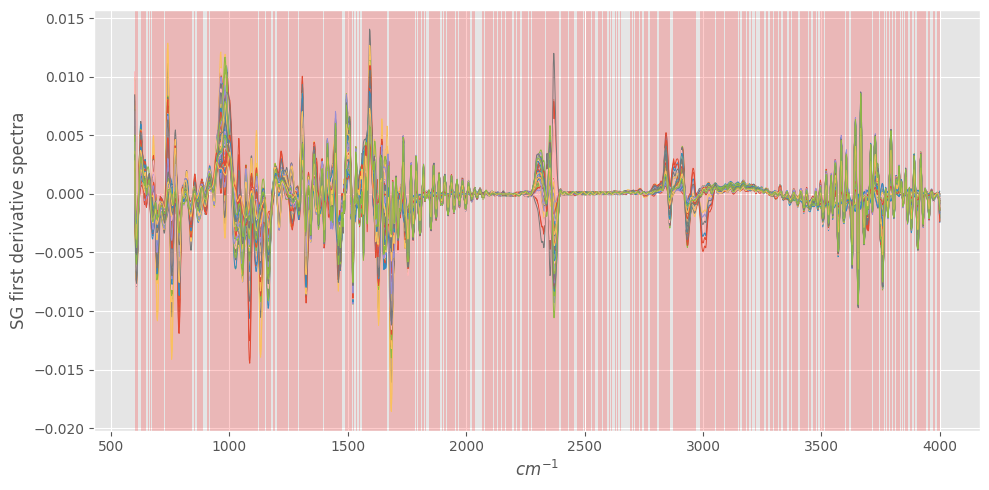

In [130]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import BrokenBarHCollection

# Optimize your data operations
ix = np.isin(wl, wl[sorted_ind][:wav])  # Simplify in1d to isin for better clarity and performance

# Create the plot
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(wl, X_train.T, linewidth = 0.7)  # Add a label for potential legend use
ax.plot(wl, X_test.T, linewidth = 0.7)  # Add a label for potential legend use
ax.set_ylabel('SG first derivative spectra')  # Use `set_` methods for clarity
ax.set_xlabel('$cm^{-1}$')

# Add highlighted regions
highlight = BrokenBarHCollection.span_where(
    wl, ymin=-6, ymax=6, where=ix, facecolor='red', alpha=0.2
)
ax.add_collection(highlight)

# Apply a style and show the plot
plt.style.use('ggplot')  # Apply style at the module level if consistent
# plt.xlim(wl[0], wl[-1])
# plt.ylim(-0.15, 0.15)
plt.tight_layout()  # Optimize layout for better spacing
plt.show()


In [131]:
X_train = X_train[:,sorted_ind][:, wav:]
X_test = X_test[:,sorted_ind][:, wav:]

In [132]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [133]:
onehot = OneHotEncoder(sparse_output=False)
y_train = onehot.fit_transform(y_train.reshape(-1,1))
y_test = onehot.fit_transform(y_test.reshape(-1,1))

In [134]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [139]:
params = {
    'wav': wav,
    'sorted_ind': sorted_ind
}

In [140]:
import pickle 
  
# Open a file and use dump() 
with open('file.pkl', 'wb') as file: 
      
    # A new file will be created 
    pickle.dump(params, file) 

In [141]:
import tensorflow as tf
import random

tf.random.set_seed(1)
random.seed(1)
np.random.seed(1)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=(X_train.shape[1], 1)))
# model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
# model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=3))
# model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=3))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
# model.add(tf.keras.layers.Conv1D(filters=16, kernel_size=3))
# model.add(tf.keras.layers.Conv1D(filters=24, kernel_size=3))
# model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(16, activation='relu'))
# model.add(tf.keras.layers.Dense(100, activation='relu'))
model.add(tf.keras.layers.Dense(y_train.shape[1], activation='softmax'))

model.compile(optimizer="Adam", loss = 'CategoricalCrossentropy', metrics = ['accuracy'])
history=model.fit(X_train, y_train, batch_size=12, epochs=24, validation_data=(X_test, y_test))

Epoch 1/24
9/9 [==============================] - 1s 36ms/step - loss: 1.3047 - accuracy: 0.4112 - val_loss: 1.2335 - val_accuracy: 0.4688
Epoch 2/24
9/9 [==============================] - 0s 8ms/step - loss: 1.0340 - accuracy: 0.6449 - val_loss: 1.0186 - val_accuracy: 0.7188
Epoch 3/24
9/9 [==============================] - 0s 8ms/step - loss: 0.8048 - accuracy: 0.7570 - val_loss: 0.8137 - val_accuracy: 0.7188
Epoch 4/24
9/9 [==============================] - 0s 9ms/step - loss: 0.5522 - accuracy: 0.8972 - val_loss: 0.5663 - val_accuracy: 0.8125
Epoch 5/24
9/9 [==============================] - 0s 10ms/step - loss: 0.3190 - accuracy: 0.9720 - val_loss: 0.4455 - val_accuracy: 0.8438
Epoch 6/24
9/9 [==============================] - 0s 10ms/step - loss: 0.1799 - accuracy: 0.9907 - val_loss: 0.3298 - val_accuracy: 0.8750
Epoch 7/24
9/9 [==============================] - 0s 10ms/step - loss: 0.0977 - accuracy: 1.0000 - val_loss: 0.2736 - val_accuracy: 0.8750
Epoch 8/24
9/9 [==============

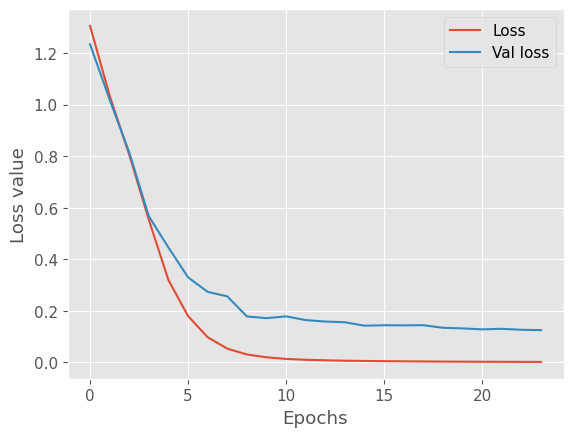

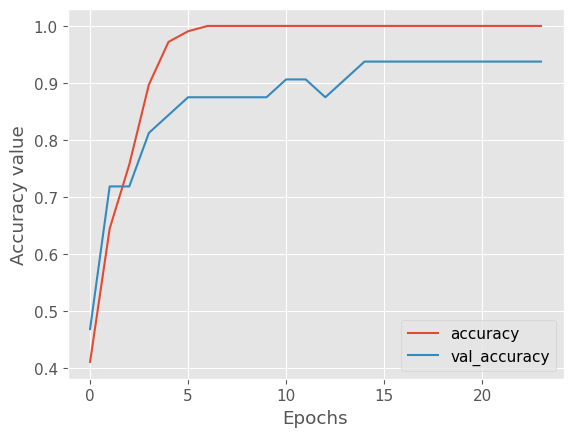

In [142]:
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy value')
plt.legend()
plt.show()

1/1 [==============================] - 0s 95ms/step
0.9375


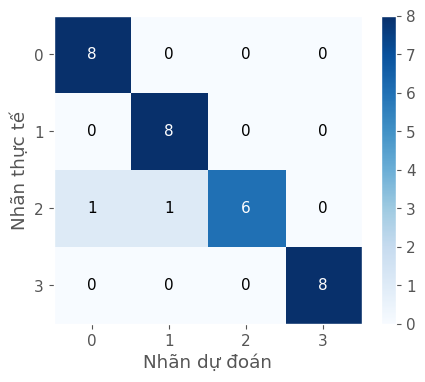

In [143]:
from mlxtend.plotting import plot_confusion_matrix
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_m = np.argmax(y_test, axis=1)
print(accuracy_score(y_test_m, y_pred))
# print(precision_score(y_test_m, y_pred))
# print(recall_score(y_test_m, y_pred))
# print(f1_score(y_test_m, y_pred))
cm = confusion_matrix(y_test_m, y_pred)
fig, ax = plot_confusion_matrix(conf_mat=cm, colorbar=True, figsize=(5,4))
plt.rcParams.update({'font.size': 11})
plt.xlabel("Nhãn dự đoán")
plt.ylabel("Nhãn thực tế")
plt.show()

In [144]:
print(classification_report(y_test_m, y_pred))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       0.89      1.00      0.94         8
           2       1.00      0.75      0.86         8
           3       1.00      1.00      1.00         8

    accuracy                           0.94        32
   macro avg       0.94      0.94      0.93        32
weighted avg       0.94      0.94      0.93        32

